In [3]:
import os
import sys
from datetime import datetime, timedelta
import time
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import StaleElementReferenceException, NoSuchElementException
import re
import string
from tqdm import tqdm

In [4]:
CHROME_DRIVER_PATH = "c:\\Users\\smazzanti\\GitProjects\\tds-crawler\\chromedriver\\chromedriver.exe"

In [5]:
def get_driver(silent=True):
    options = webdriver.chrome.options.Options()
    options.headless = silent
    driver = webdriver.Chrome(executable_path=CHROME_DRIVER_PATH, chrome_options=options)
    return driver


def clean_url(user_url):
    return user_url.split('?source=')[0].rstrip("/")


def date_description_to_date(string):
    """
    Turn a string into a date. 

    Examples:
    - "2 days ago" -> date(2022, 12, 23)
    - "Dec 23" -> date(2022, 12, 23)
    - "Dec 23, 2022" -> date(2022, 12, 23)
    """

    MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    string_split = [s for s in re.split('[^a-zA-Z0-9]', string) if s]
    current_date = datetime.now().date()

    if len(string_split) == 3 and string_split[2] == "ago":
        days_ago = int(string_split[0]) if string_split[1] in ["day", "days"] else 0
        reference_date = current_date - timedelta(days=days_ago)
    elif string_split[0] in MONTHS:
        month = MONTHS.index(string_split[0]) + 1
        day = int(string_split[1])
        year = int(string_split[2]) if len(string_split) == 3 else current_date.year
        reference_date = datetime(year=year, month=month, day=day).date()            
    else:
        reference_date = None
    
    return reference_date

In [4]:
def retrieve_from_article(article_url, retrieve_claps=True, driver=None, quit_driver=True):
    """Retrieve information from article url."""
    driver = get_driver() if driver is None else driver
    driver.get(article_url)
    
    time.sleep(2)

    claps_str = driver.find_element_by_xpath("/html/body/div[.]/div/div[.]/div[.]/div/main/div/div[.]/div/div[.]/div[.]/div/div[.]/p/button").text

    info = {
        "ref_date": datetime.now().date(), 
        "article_url": article_url,
        "n_claps": int(eval(claps_str.replace("K", "*1000")))
    }

    if quit_driver:
        driver.quit()

    return info

#out = retrieve_from_article("https://medium.com/towards-data-science/what-is-better-one-general-model-or-many-specialized-models-9500d9f8751d")

In [5]:
def retrieve_from_user(user_url=None, driver=None, quit_driver=True, timeout=300):
    """Retrieve information from a user url."""
    driver = get_driver(silent=True) if driver is None else driver
    driver.get(user_url) if user_url is not None else None

    # init
    articles_info = []
    start_time = time.time()
    last_scroll_height = 0
    stopping_reason = None 

    # scroll page until end of page or more than 300 seconds have passed
    while not stopping_reason:
        new_scroll_height = driver.execute_script("return document.body.scrollHeight")
        if new_scroll_height == last_scroll_height:
            stopping_reason = "end_of_page"
        elif time.time() - start_time > timeout:
            stopping_reason = "timeout"
        else:
            last_scroll_height = new_scroll_height
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)

    articles = driver.find_elements_by_xpath("/html/body/div/div/div[3]/div[2]/div/main/div/div[2]/div/div/article[.]")
    for article in articles:
        try:
            article_publication = article.find_elements_by_xpath("./div/div/div/div/div/div[1]/div[2]/div[1]/div/span/a")
            article_date = article.find_element_by_xpath("./div/div/div/div/div/div[1]/div[2]/div[2]/span/div/a/p").text
            article_title = article.find_element_by_xpath("./div/div/div/div/div/div[2]/div/div[1]/div/div/div/div[1]/div[1]/div[1]/a")
            articles_info.append({
                "ref_date": datetime.now().date(),
                "article_url": clean_url(article_title.get_attribute("href")),
                "article_date": date_description_to_date(article_date),
                "article_publication": clean_url(article_publication[0].get_attribute('href')) if article_publication else None,
                "article_title": article_title.text.split("\n")[0]
            })
        except:
            pass

    user_name = driver.find_element_by_xpath("/html/body/div/div/div[3]/div[2]/div/main/div/div[1]/div/div/div/div/div[1]/div[2]/div[1]/div/a").text
    driver.get(user_url + "/followers")
    n_followers = int(driver.find_element_by_xpath("//h2[contains(text(), ' Followers')]").text.rstrip(" Followers").replace(".", "").replace(",", ""))
    user_info = {
        "ref_date": datetime.now().date(),
        "user_url": user_url,
        "user_name": user_name,
        "n_articles": len(articles),
        "n_followers": n_followers
    }

    if quit_driver:
        driver.quit()
    
    return user_info, articles_info

#out = retrieve_from_user(user_url="https://medium.com/@mazzanti.sam") # "https://medium.com/@camilleoutsidethebox"

In [6]:
def retrieve_from_publication_article(article, publication_url):
    article_url = clean_url(article.find_element_by_xpath("./div/div/div/div/div/div[2]/div/div[1]/div/div/div/div[1]/div[1]/div[1]/a").get_attribute('href'))
    author = article.find_element_by_xpath("./div/div/div/div/div/div[1]/div[2]/div[1]/div/span/div/a")
    author_url = clean_url(author.get_attribute('href'))
    author_name = author.text
    article_date = date_description_to_date(article.find_element_by_xpath("./div/div/div/div/div/div[1]/div[2]/div[2]/span/div/a/p").text)
    return {
        "ref_date": datetime.now().date(),
        "publication_url": publication_url,
        "article_url": article_url,
        "author_url": author_url,
        "author_name": author_name,
        "article_date": article_date
    }

In [20]:
def retrieve_from_publication(
    publication_url=None, 
    driver=None, 
    quit_driver=True, 
    timeout=60, 
    min_date=datetime(year=2022, month=1, day=1).date(), 
    silent=True
):
    """Retrieve information from a user url."""
    driver = get_driver() if driver is None else driver
    driver.get(publication_url) if publication_url is not None else None

    start_time = time.time()
    last_scroll_height = 0
    last_article_date = datetime(9999,12,31).date()
    stopping_reason = None

    while not stopping_reason:
        try:
            new_scroll_height = driver.execute_script("return document.body.scrollHeight")
            if new_scroll_height == last_scroll_height:
                stopping_reason = "end_of_page"
            elif time.time() - start_time > timeout:
                stopping_reason = "timeout"
            elif last_article_date < min_date:
                stopping_reason = "article_date"
            else:
                last_scroll_height = new_scroll_height
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                articles = driver.find_elements_by_xpath("/html/body/div/div/div[3]/div[2]/div/main/div/div[2]/div/article[.]")
                last_article_date = retrieve_from_publication_article(articles[-1], publication_url)["article_date"]
            
            if not silent:
                print(f"n. articles: {len(articles)}, last article date: {last_article_date}")
        except Exception as e:
            print(e)
            break

    info = [retrieve_from_publication_article(article, publication_url) for article in articles]

    if quit_driver:
        driver.quit()

    return info

In [12]:
#out = retrieve_from_publication(
#    publication_url="https://towardsdatascience.com/",
#    timeout=60*60*5,
#    min_date=datetime(year=2022, month=7, day=1).date(),
#    silent=False
#)

C:\Users\smazzanti\PycharmProjects\mrmr\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


list index out of range


In [15]:
articles = pd.DataFrame(out)
articles["publication_url"] = "https://towardsdatascience.com/"
articles.to_csv("articles_20230102.csv", sep ='\t', index=False)

In [8]:
year = 2022
month = 12
day = 7



C:\Users\smazzanti\PycharmProjects\mrmr\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


In [19]:
archive_url = "https://towardsdatascience.com/archive/2022/12/09"



#driver.quit()

C:\Users\smazzanti\PycharmProjects\mrmr\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


In [24]:
start_date = datetime(2022, 1, 1).date()
end_date = datetime(2022, 1, 1).date()

driver = get_driver(silent=True)

articles_info = list()

dates = [start_date + timedelta(days=days) for days in range((end_date - start_date).days + 1)]

for article_date in tqdm(dates):
    archive_url = datetime.strftime(article_date, 'https://towardsdatascience.com/archive/%Y/%m/%d')
    driver.get(archive_url)

    try:
        articles = driver.find_elements_by_xpath("/html/body/div[1]/div[2]/div/div[3]/div[1]/div[2]/div[.]")
    except:
        articles = []

    for article in articles:
        article_url = clean_url(article.find_element_by_xpath("./div/div/div[2]/a").get_attribute("href"))
        article_title = article.find_element_by_tag_name("h3").text                                   
        user = article.find_element_by_xpath("./div/div/div[1]/div/div/div[2]/a[1]")
        user_url = clean_url(user.get_attribute("href"))
        user_name = user.text
        reading_time = int(article.find_element_by_class_name("readingTime").get_attribute("title").split(" ")[0])
        n_claps = int(eval(article.find_element_by_xpath("./div/div/div[4]/div[1]/div/span").text.zfill(1).replace("K", "*1000")))
        article_info = {
            "ref_date": datetime.now().date(),
            "article_url": article_url,
            "article_title": article_title,
            "article_date": article_date,
            "user_url": user_url,
            "user_name": user_name,
            "reading_time": reading_time,
            "n_claps": n_claps
        }
        articles_info.append(article_info)

C:\Users\smazzanti\PycharmProjects\mrmr\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.
100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


In [25]:
pd.DataFrame(articles_info)

,ref_date,article_url,article_title,article_date,user_url,user_name,reading_time,n_claps
0,2023-01-03,https://towardsdatascience.com/5-ways-to-deal-...,3 ways to deal with large datasets in Python,2022-01-01,https://towardsdatascience.com/@georgiadeaconu,Georgia Deaconu,3,295
1,2023-01-03,https://towardsdatascience.com/from-supervised...,From Supervised To Unsupervised Learning: A Pa...,2022-01-01,https://towardsdatascience.com/@leon.sick,Leon Sick,6,162
2,2023-01-03,https://towardsdatascience.com/top-python-libr...,Top Python Libraries for Visualization: A Star...,2022-01-01,https://towardsdatascience.com/@mzabolocki,Michael Zabolocki,8,64
3,2023-01-03,https://towardsdatascience.com/simple-method-o...,Simple method of targeted TF-IDF topic modelin...,2022-01-01,https://towardsdatascience.com/@kenhua15,Kenneth Hua,5,20
4,2023-01-03,https://towardsdatascience.com/optimizing-pati...,Optimizing Patient Scheduling,2022-01-01,https://towardsdatascience.com/@gabeverzino,Gabe Verzino,10,27
5,2023-01-03,https://towardsdatascience.com/identifying-pla...,Plagiarism Detection in Online Exams using Mac...,2022-01-01,https://towardsdatascience.com/@christopher-ge...,Christopher Gerling,9,66
6,2023-01-03,https://towardsdatascience.com/shooting-star-p...,Shooting Star Problem — Simple Solution and Po...,2022-01-01,https://towardsdatascience.com/@surajregmi,Suraj Regmi,4,140
7,2023-01-03,https://towardsdatascience.com/why-your-dashbo...,Why Your Dashboards Are Ignored,2022-01-01,https://towardsdatascience.com/@madfordata,Vicky Yu,3,108
8,2023-01-03,https://towardsdatascience.com/fooled-by-taylo...,Fooled by the Taylor Series,2022-01-01,https://towardsdatascience.com/@rohan-tangri,Rohan Tangri,4,14
9,2023-01-03,https://towardsdatascience.com/power-bi-an-ana...,Power BI — An analogy with cupcakes!,2022-01-01,https://towardsdatascience.com/@peter-hui,Peter Hui,4,9


In [11]:
article.find_element_by_xpath("./div/div/div[1]/div/div/div[2]/div/span[2]").text

''

In [ ]:
#_obv\.shell\._surface_1672731779535 > div > div.container.u-maxWidth1040.u-marginTop30 > div.col.u-xs-size12of12.u-size8of12.u-padding0 > div.u-marginTop25.js-postStream > div:nth-child(1) > div > div > div.u-clearfix.u-marginBottom15.u-paddingTop5 > div > div > div.postMetaInline.postMetaInline-authorLockup.ui-captionStrong.u-flex1.u-noWrapWithEllipsis > div > span.readingTime

In [94]:
df_articles.groupby("article_date").count().iloc[:,0]

article_date
2022-01-01    10
2022-01-02    18
2022-01-03    38
2022-01-04    41
2022-01-05    50
              ..
2022-04-05    17
2022-04-06    26
2022-04-07    20
2022-04-08    21
2022-04-09     5
Name: ref_date, Length: 99, dtype: int64

In [89]:
df_articles = pd.DataFrame(articles_info)

df_articles.shape

(2338, 7)

In [ ]:
df_articles.to_csv("articles_20230102.csv", sep ='\t', index=False)

In [96]:
df_articles["n_claps"].describe()

count    2338.000000
mean      130.017109
std       184.489618
min         0.000000
25%        30.000000
50%        72.500000
75%       156.000000
max      2000.000000
Name: n_claps, dtype: float64

In [ ]:
df_

In [33]:
driver = get_driver()

users = pd.DataFrame(columns=["ref_date", "user_url", "n_followers"])

for enum, user_url in tqdm(enumerate(articles["author_url"].unique())):
    user_followers_url = user_url + "/followers"
    driver.get(user_followers_url)
    followers_count = int(driver.find_element_by_xpath("//h2[contains(text(), ' Followers')]").text.rstrip(" Followers").replace(".", "").replace(",", ""))
    users.loc[enum, :] = user_url, datetime.now().date(), followers_count

C:\Users\smazzanti\PycharmProjects\mrmr\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.
0it [00:04, ?it/s]


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//h2[contains(text(), ' Followers')]"}
  (Session info: headless chrome=108.0.5359.125)


In [35]:
driver = get_driver(silent=False)

driver.get('https://medium.com/@mary.newhauser/followers')

C:\Users\smazzanti\PycharmProjects\mrmr\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


In [10]:
users = users[["user_url", "reference_date", "followers"]]

In [9]:
users["reference_date"] = datetime.now().date()
users = users[["user_url", "reference_date", "followers"]]

,user_url,reference_date,followers
0,https://towardsdatascience.medium.com,2022-12-31,49397
1,https://medium.com/@mazzanti.sam,2022-12-31,3835
2,https://medium.com/@eortizrecalde,2022-12-31,81
3,https://medium.com/@dinabavli,2022-12-31,76
4,https://destingong.medium.com,2022-12-31,1775
...,...,...,...
442,https://pecciaf.medium.com,2022-12-31,85
443,https://cognitivedave.medium.com,2022-12-31,212
444,https://ilro.medium.com,2022-12-31,1273
445,https://timeseriesreasoning.medium.com,2022-12-31,3877


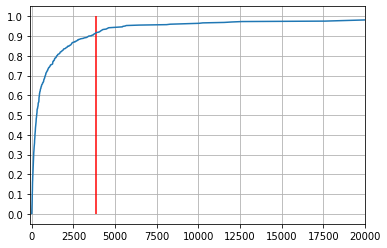

In [31]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
ecdf = ECDF(users["followers"])
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-100, 20000)
plt.vlines(3835, 0, 1, color="red")
plt.yticks(np.linspace(0,1,11))
plt.grid()

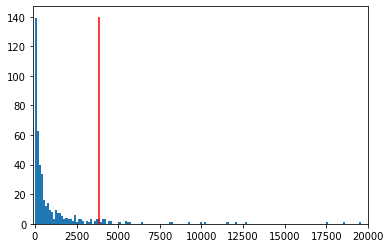

In [27]:
plt.hist(users["followers"], bins=1000)
plt.xlim(-100, 20000)
plt.vlines(3835, 0, 140, color="red")

In [16]:
users["followers"].astype(int).describe(percentiles=np.linspace(0,1,11))

count       447.000000
mean       2295.577181
std       10482.469495
min           3.000000
0%            3.000000
10%          32.600000
20%          68.000000
30%         117.000000
40%         194.200000
50%         294.000000
60%         459.600000
70%         819.800000
80%        1514.600000
90%        3481.800000
100%     122350.000000
max      122350.000000
Name: followers, dtype: float64

In [18]:
(users["followers"] > 3835).sum() / len(users)

0.08501118568232663

In [32]:
users[users["followers"] > 3500].sort_values("followers")

,user_url,reference_date,followers
77,https://rukshanpramoditha.medium.com,2022-12-31,3585
256,https://ngwaifoong92.medium.com,2022-12-31,3610
13,https://carolinabento.medium.com,2022-12-31,3709
46,https://madison-schott.medium.com,2022-12-31,3717
390,https://manuel-brenner.medium.com,2022-12-31,3746
304,https://romanmichaelpaolucci.medium.com,2022-12-31,3822
1,https://medium.com/@mazzanti.sam,2022-12-31,3835
445,https://timeseriesreasoning.medium.com,2022-12-31,3877
145,https://medium.com/@avi_chawla,2022-12-31,4013
39,https://medium.com/@kenneth.b.jee,2022-12-31,4077


In [15]:
users.sort_values("followers", ascending=False)

,user_url,reference_date,followers
398,https://medium.com/@JeremieHarris,2022-12-31,122350
249,https://kozyrkov.medium.com,2022-12-31,114733
154,https://terenceshin.medium.com,2022-12-31,112570
0,https://towardsdatascience.medium.com,2022-12-31,49397
63,https://medium.com/@SeattleDataGuy,2022-12-31,49055
...,...,...,...
231,https://medium.com/@kbmuralidhar,2022-12-31,10
109,https://medium.com/@liatzheng,2022-12-31,10
207,https://medium.com/@asphadmin,2022-12-31,7
373,https://medium.com/@matthias.graeber,2022-12-31,4
